TASK 1 : Rating Prediction via Prompting

In [1]:
import pandas as pd
import json
import time
from tqdm import tqdm
import os
import re


In [2]:
df = pd.read_csv("yelp.csv") 


In [3]:
df = df[['text', 'stars']].dropna()


In [4]:
df = df.sample(40, random_state=42)


In [5]:
df.head()

,text,stars
6252,We got here around midnight last Friday... the...,4
4684,Brought a friend from Louisiana here. She say...,5
1731,"Every friday, my dad and I eat here. We order ...",3
4742,"My husband and I were really, really disappoin...",1
4521,Love this place! Was in phoenix 3 weeks for w...,5


Gemini setup

In [6]:
from openai import OpenAI

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="api_key"
)


In [7]:
def call_llm(prompt):
    response = client.chat.completions.create(
        model="meta-llama/llama-3.1-8b-instruct",
        messages=[
            {"role": "system", "content": "You are a JSON-only API."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.0,
        max_tokens=150
    )
    return response.choices[0].message.content.strip()


In [8]:
PROMPT_1 = """
You are a Yelp review rating classifier. Analyze the following review and predict a star rating from 1 to 5.

Review: "{review}"

Return ONLY a valid JSON object exactly like this:
{{"predicted_stars": number, "explanation": "Brief reasoning, 1-2 sentences"}}

Do NOT include any text outside the JSON object.
"""


In [9]:
PROMPT_2 = """
You are an expert Yelp review analyst.

Assign stars using:
1 = Very negative
2 = Mostly negative
3 = Average / mixed
4 = Mostly positive
5 = Extremely positive

Review: "{review}"

Return ONLY a valid JSON object exactly like this:
{{"predicted_stars": number, "explanation": "One sentence"}}

Do NOT include any text outside the JSON object.
"""


In [10]:
PROMPT_3 = """
Compare this review to typical characteristics of 1-5 star reviews:

★☆☆☆☆ (1-star): Terrible experience, major complaints, warnings to avoid
★★☆☆☆ (2-star): Poor experience, significant issues, not recommended
★★★☆☆ (3-star): Average experience, some good some bad, neutral
★★★★☆ (4-star): Good experience, minor issues, recommended
★★★★★ (5-star): Excellent experience, highly praised, strongly recommended

Review: "{review}"

Return ONLY a valid JSON object exactly like this:
{{"predicted_stars": number, "explanation": "Concise explanation matching the chosen category"}}

Do NOT include any text outside the JSON object.
"""


In [11]:

def extract_json(text):
    match = re.search(r'\{.*\}', text, re.DOTALL)
    if match:
        return match.group()
    return None


def evaluate_prompt(prompt_template, dataframe):
    correct = 0
    valid_json = 0

    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        prompt = prompt_template.format(review=row["text"])

        try:
            response = call_llm(prompt)

            json_text = extract_json(response)
            if json_text is None:
                raise ValueError("No JSON found")

            parsed = json.loads(json_text)

            if "predicted_stars" not in parsed:
                raise ValueError("Missing predicted_stars")

            predicted = int(str(parsed["predicted_stars"]).strip())
            actual = int(row["stars"])

            valid_json += 1
            if predicted == actual:
                correct += 1

        except Exception as e:
            
            # Uncomment next 2 lines ONLY if debugging
            print("Error:", e)
            print("Response:", response)
            pass

        time.sleep(2)

    accuracy = correct / len(dataframe)
    json_validity = valid_json / len(dataframe)

    return accuracy, json_validity


In [12]:
results = []

for name, prompt in [
    ("Direct Classification Prompt", PROMPT_1),
    ("Criteria-Based Prompt", PROMPT_2),
    ("Comparative Analysis Promppt", PROMPT_3)
]:
    print(f"Evaluating: {name}")
    accuracy, json_validity = evaluate_prompt(prompt, df)

    results.append({
        "Prompt Version": name,
        "Accuracy": round(accuracy, 3),
        "JSON Validity": round(json_validity, 3)
    })


Evaluating: Direct Classification Prompt


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:26<00:00,  3.67s/it]


Evaluating: Criteria-Based Prompt


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:15<00:00,  3.40s/it]


Evaluating: Comparative Analysis Promppt


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:07<00:00,  3.19s/it]


In [13]:
comparison_df = pd.DataFrame(results)

In [14]:
comparison_df

,Prompt Version,Accuracy,JSON Validity
0,Direct Classification Prompt,0.725,1.0
1,Criteria-Based Prompt,0.700,1.0
2,Comparative Analysis Promppt,0.625,1.0


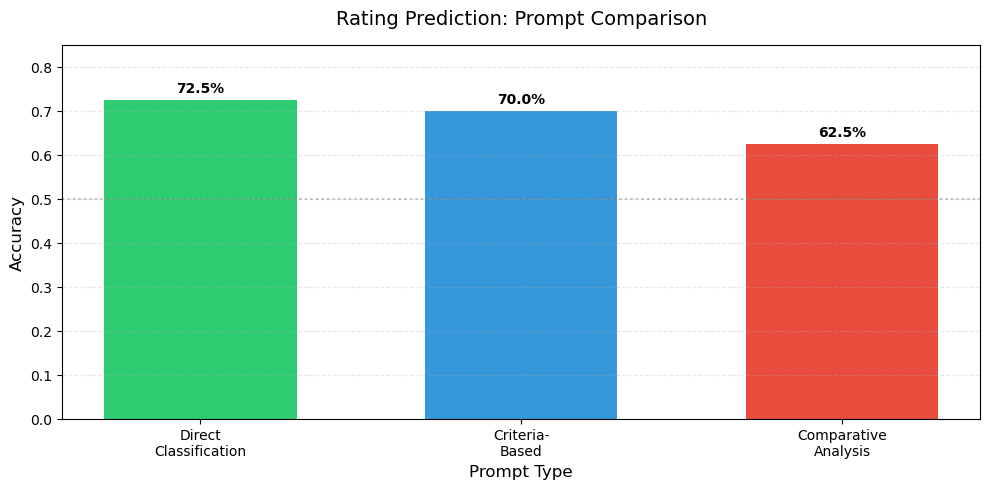

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

labels = ['Direct', 'Criteria', 'Comparative']
x_pos = range(len(labels))


bars = plt.bar(x_pos, comparison_df['Accuracy'], 
               color=['#2ecc71', '#3498db', '#e74c3c'], 
               width=0.6)


plt.title('Rating Prediction: Prompt Comparison', fontsize=14, pad=15)
plt.xlabel('Prompt Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)


plt.xticks(x_pos, ['Direct\nClassification', 'Criteria-\nBased', 'Comparative\nAnalysis'])


for bar, acc in zip(bars, comparison_df['Accuracy']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')


plt.ylim(0, 0.85)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()